# Réflexions autour du voyage de commerce (TSP)

Le [problème du voyageur de commerce](http://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce) consiste à trouver le plus court chemin passant par toutes les villes. On parle aussi de [circuit hamiltonien](http://en.wikipedia.org/wiki/Hamiltonian_path) qui consiste à trouver le plus court chemin passant par tous les noeuds d'un graphe. Ce problème est [NP-complet](http://fr.wikipedia.org/wiki/Probl%C3%A8me_NP-complet) à savoir qu'il n'existe pas d'algorithme qui permette de trouver la solution avec un coût polynômiale. C'est aussi un problème différent du [plus court chemin dans un graphe](http://fr.wikipedia.org/wiki/Probl%C3%A8mes_de_cheminement) qui consiste à trouver le plus court chemin reliant deux noeuds d'un graphe (mais pas forcément tous les noeuds de ce graphe).

In [1]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt
import sys

In [2]:
def read_numbers(data_file):
    input_data_file = open(data_file, 'r')
    input_data = input_data_file.readlines()
    input_data_file.close()

    numbers = np.array([])
    for i_line in range(len(input_data)):
        entries = input_data[i_line].split()
        entries = filter(None, entries) # remove empty entries
        line_numbers = [ float(x) if x.lower != "inf" else float("inf") for x in entries ]
        numbers = np.append(numbers, line_numbers)
    return numbers


def read_data(data_file):
    numbers = read_numbers(data_file)
    cur_entry = 0

    # number of points
    num_points = int(numbers[cur_entry])
    cur_entry += 1

    # get data on the points
    points = np.zeros((num_points, 2))
    for i_point in range(num_points):
        points[i_point, 0] = float(numbers[cur_entry])
        cur_entry += 1
        points[i_point, 1] = float(numbers[cur_entry])
        cur_entry += 1

    return points


def dist(A, B):
    return math.sqrt( (A[0] - B[0]) * (A[0] - B[0]) + (A[1] - B[1]) * (A[1] - B[1]) )


def check_tsp_solution( solution, points ):
    num_points = points.shape[0]
    visited_nodes = np.zeros(num_points, dtype=bool)
    path_length = dist( points[solution[0]], points[solution[-1]] )
    for i_point in range(num_points-1):
        visited_nodes[i_point] = True
        path_length += dist( points[solution[i_point]], points[solution[i_point+1]] )

    is_valid_solution = False in visited_nodes
    return is_valid_solution, path_length


def plot_tsp_solution(solution, points):
    is_valid_solution, path_length = check_tsp_solution( solution, points )

    x = np.hstack((points[solution][:,0], points[solution[0]][0]))
    y = np.hstack((points[solution][:,1], points[solution[0]][1]))
    plt.plot(x, y, "o-")
    plt.xlabel('x')
    plt.ylabel('y')
    solution_quality = ['Inconsistent', 'Valid']
    plt.title( '%s solution; %d points; length = %f'%(solution_quality[is_valid_solution], len(points), path_length) )
    plt.show(block=True)

On lance le test :

test sample number : 1


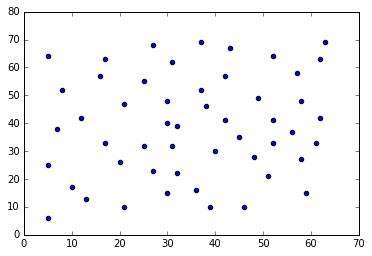

In [3]:
#k = input("test sample number : ")
k = 1  # pour l'instant on se concentre sur le test 1
path = "task3_test{}.txt".format(k)
points = read_data(path)
x, y = points.T[0], points.T[1]
plt.scatter(points.T[0], points.T[1])
plt.show()
#plot_tsp_solution(solution, points)
#print(' '.join(map(str, solution)))

Un parcours aléatoire de tous les noeuds de graphe donnera quelque chose de très éloigné de la solution optimale :

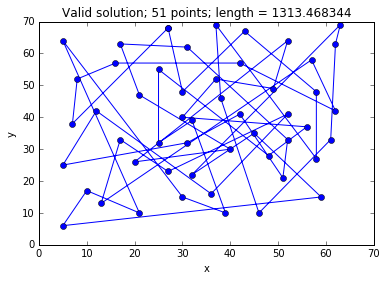

In [4]:
solution_value, solution = make_dummy_solution(points)
plot_tsp_solution(solution, points)

La première constation est que le chemin ne peut pas être optimal car des arcs se croisent. On en déduit qu'une façon d'améliorer ce chemin est de _décroiser_ certaines parties. On peut par exemple choisir deux points au hasard, retourner la partie du chemin au milieu de ces deux points et voir si la longueur du chemin s'en trouve diminuée. On peut également parcourir toutes les paires de noeuds possibles. C'est ce qui est implémenté ci-dessous.

longueur initiale 1313.4683444443458
iteration 2 d= 1313.4683444443458
iteration 3 d= 547.2376166870717
iteration 4 d= 486.17250158847565
iteration 5 d= 467.92391944214864
iteration 6 d= 467.9239194421486
longueur min 467.9239194421486


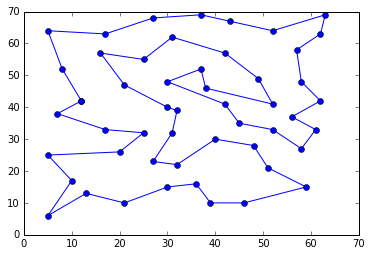

In [5]:
def longueur(ordre):
    i = ordre[-1]
    x0, y0 = x[i], y[i]
    d = 0
    for o in ordre:
        x1, y1 = x[o], y[o]
        d += math.sqrt((x0-x1)**2 + (y0-y1)**2)
        x0, y0 = x1, y1
    return d

ordre = np.arange(len(x))
print("longueur initiale", longueur(ordre))

def permutation(ordre):
    d = longueur(ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration", it, "d=", d)
        d0 = d
        for i in range(0,len(ordre)-1) :
            for j in range(i+2,len(ordre)):
                r = ordre[i:j].copy()
                r.reverse()
                ordre2 = ordre[:i] + r + ordre[j:]
                t = longueur(ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation(list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")

Voilà qui est mieux. Maintenant, supposons que nous faisons une erreur lors du calcul de la distance : nous oublions le dernier arc qui boucle le chemin du dernier noeud au premier.

longueur initiale 1277.4128316897063
iteration 2 d= 1277.4128316897063
iteration 3 d= 497.897915124231
iteration 4 d= 455.58174135409973
iteration 5 d= 452.4143488484369
longueur min 452.4143488484369


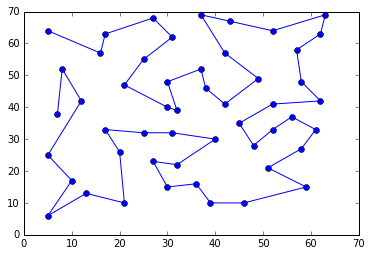

In [6]:
def longueur (x,y, ordre):
    # on change cette fonction
    d = 0
    for i in range(1,len(ordre)):
        n = ordre[i-1]
        o = ordre[i]
        x0,y0 = x[n], y[n]
        x1,y1 = x[o], y[o]
        d += math.sqrt((x0-x1)**2 + (y0-y1)**2)
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre]
yo = [ y[o] for o in ordre]
plt.plot(xo,yo, "o-")

Jusque ici, tout concorde. Le chemin est plus court en ce sens qu'il oublie délibérément l'arc de bouclage que l'algorithme a tendance à choisir grand. Pour gagner du temps de calcul, un développeur se dit que le noeud de départ peut être constant. Après tout, le chemin est une boucle, elle passera toujours par le premier noeud. Qu'il soit en première position ne change rien et puis inverser une moitié, c'est équivalent à inverser l'autre moitié. On fait donc juste une modification :

longueur initiale 1313.4683444443458
iteration 2 d= 1313.4683444443458 ordre[0] 0
iteration 3 d= 561.0141125334193 ordre[0] 0
iteration 4 d= 498.55244472237996 ordre[0] 0
iteration 5 d= 488.7379492252877 ordre[0] 0
longueur min 488.7379492252877


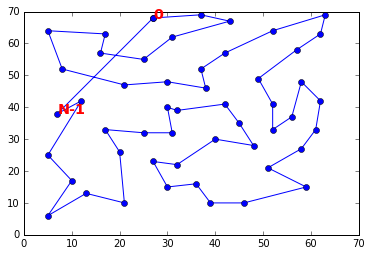

In [7]:
def longueur (x,y, ordre):
    i = ordre[-1]
    x0,y0 = x[i], y[i]
    d = 0
    for o in ordre:
        x1,y1 = x[o], y[o]
        d += math.sqrt((x0-x1)**2 + (y0-y1)**2)
        x0,y0 = x1,y1
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation(x,y,ordre):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration",it, "d=",d, "ordre[0]", ordre[0])
        d0 = d
        for i in range(1,len(ordre)-1) :  # on part de 1 et plus de 0, on est sûr que le premier noeud ne bouge pas
            for j in range(i+2,len(ordre)):
                r = ordre[i:j].copy()
                r.reverse()
                ordre2 = ordre[:i] + r + ordre[j:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation(x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]] ]
yo = [ y[o] for o in ordre + [ordre[0]] ]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")

Le résultat attendu n'est pas celui qu'on observe. Est-ce une erreur d'implémentation ou une erreur de raisonnement ? J'étais pourtant sûr que mon raisonnement était correct et j'aurais tort d'en douter. C'est une erreur d'implémentation. Lorsqu'on``for j in range(i+2,len(ordre)):`` et  ``r = ordre[i:j].copy()``, on écrit que ``j`` va de ``i+2`` inclus à ``len(ordre)`` exclu. Puis lorsqu'on écrit ``ordre[i:j]``, l'indice ``j`` est exclu ! Autrement dit, dans cette implémentation, le premier noeud et le dernier noeud ne bougeront jamais ! On s'empresse de corriger cela.

longueur initiale 1313.4683444443458
iteration 2 d= 1313.4683444443458 ordre[0] 0
iteration 3 d= 569.8267330582909 ordre[0] 0
iteration 4 d= 476.0604876198756 ordre[0] 0
iteration 5 d= 457.0186129119234 ordre[0] 0
longueur min 457.0186129119234


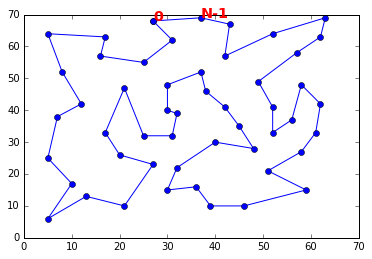

In [8]:
ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation(x,y,ordre):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration",it, "d=",d, "ordre[0]", ordre[0])
        d0 = d
        for i in range(1,len(ordre)-1) :  # on part de 1 et plus de 0, on est sûr que le premier noeud ne bouge pas
            for j in range(i+2,len(ordre)+ 1):  # correction !
                r = ordre[i:j].copy()
                r.reverse()
                ordre2 = ordre[:i] + r + ordre[j:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")

Pas parfait mais conforme à nos attentes (les miennes en tout cas) ! Soit dit en passant, la première version de l'algorithme laissait déjà le dernier noeud inchangé. 

La solution n'est pas parfaite en ce sens que visuellement, on voit que certaines partie du chemin pourraient être facilement améliorées. Mais si la solution était parfaite en toute circonstance, nous aurions trouvé un algorithme à temps polynômial ce qui est impossible. Dans notre cas, l'algorithme produit toujours la même solution car il parcourt les noeuds toujours dans le même sens. Un peu d'aléa devrait l'aider à trouver de meilleures solutions après quelques essais.

longueur initiale 1313.4683444443458
iteration 2 d= 1313.4683444443458 ordre[0] 0
iteration 3 d= 563.0600444130101 ordre[0] 0
iteration 4 d= 491.91194799146797 ordre[0] 0
iteration 5 d= 470.6146038461463 ordre[0] 0
iteration 6 d= 463.04633288967335 ordre[0] 0
iteration 7 d= 458.7999740358943 ordre[0] 0
iteration 8 d= 446.35536151859844 ordre[0] 0
iteration 9 d= 444.847625959487 ordre[0] 0
longueur min 444.847625959487


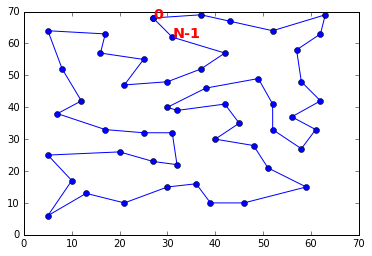

In [9]:
ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation_rnd(x,y,ordre):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration",it, "d=",d, "ordre[0]", ordre[0])
        d0 = d
        for i in range(1,len(ordre)-1) :  
            for j in range(i+2,len(ordre)+ 1): 
                k = random.randint(1,len(ordre)-1)
                l = random.randint(k+1,len(ordre))
                r = ordre[k:l].copy()
                r.reverse()
                ordre2 = ordre[:k] + r + ordre[l:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation_rnd (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")

Ca a l'air de marcher un peu mieux mais quelques aberrations car l'aléatoire n'est pas un parcours systématique de toutes les pairs. Par conséquent, il peut rester des croisements :

iteration 2 d= 1313.4683444443458 ordre[0] 0
iteration 3 d= 553.5453435710577 ordre[0] 0
iteration 4 d= 500.3095754338704 ordre[0] 0
iteration 5 d= 463.3977641880987 ordre[0] 0
iteration 6 d= 461.894155900611 ordre[0] 0
longueur min 461.894155900611


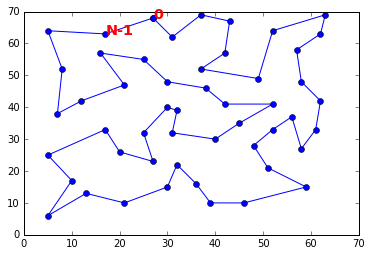

In [10]:
ordre = permutation_rnd (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")

Pour éviter cela, on peut imposer un nombre d'itérations minimum et recommencer plusieurs à partir d'ordre initiaux aléatoires :

longueur initiale 1313.4683444443458
iteration 0 d= 1313.4683444443458
iteration 1 d= 429.5302833416998
iteration 2 d= 429.5302833416998
iteration 3 d= 429.5302833416998
iteration 4 d= 429.5302833416998
iteration 5 d= 429.5302833416998
iteration 6 d= 429.5302833416998
iteration 7 d= 429.5302833416998
iteration 8 d= 429.5302833416998
iteration 9 d= 429.5302833416998
iteration 10 d= 429.5302833416998
iteration 11 d= 429.5302833416998
iteration 12 d= 429.5302833416998
iteration 13 d= 429.5302833416998
iteration 14 d= 429.5302833416998
iteration 15 d= 429.5302833416998
iteration 16 d= 429.5302833416998
iteration 17 d= 429.5302833416998
iteration 18 d= 429.5302833416998
iteration 19 d= 429.5302833416998
longueur min 429.5302833416998


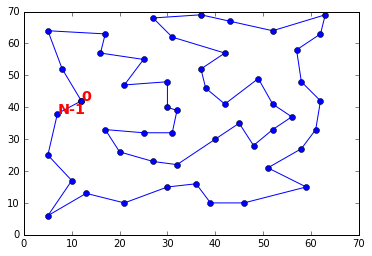

In [11]:
ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation_rnd(x,y,ordre,miniter):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 or it < miniter :
        it += 1
        d0 = d
        for i in range(1,len(ordre)-1) :  
            for j in range(i+2,len(ordre)+ 1): 
                k = random.randint(1,len(ordre)-1)
                l = random.randint(k+1,len(ordre))
                r = ordre[k:l].copy()
                r.reverse()
                ordre2 = ordre[:k] + r + ordre[l:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

def n_permutation(x,y, miniter):
    ordre = list(range(len(x)))
    bordre = ordre.copy()
    d0 = longueur(x,y,ordre)
    for i in range(0,20):
        print("iteration",i, "d=",d0)
        random.shuffle(ordre)
        ordre = permutation_rnd (x,y,ordre, 20)
        d = longueur(x,y,ordre)
        if d < d0 :
            d0 = d
            bordre = ordre.copy()
    return bordre

ordre = n_permutation(x,y, 20)
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")

C'est mieux.